In [1]:
from rdkit import Chem
import pickle
import numpy as np
import pandas as pd
from IPython.display import display
from copy import deepcopy

# Load processed data

In [2]:
dataset = pd.read_csv("/home/abhor/Desktop/datasets/my_uspto/processed_data.csv", index_col=0)

In [3]:
dataset

,reactants,reagents,products
0,CON(C)C(=O)c1ccc(O)nc1,C1CCOC1.[Cl-],CC(C)CC(=O)c1ccc(O)nc1
1,O=C(O)c1ccc(Cl)c([N+](=O)[O-])c1,O,CNc1ccc(C(=O)O)cc1[N+](=O)[O-]
2,CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(N)cc3)cc21,NaN,CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(NC=O)cc3)cc21
3,COCC(C)Oc1cc(Oc2cnc(C(=O)N3CCC3)cn2)cc(C(=O)O)c1,CC(C)=C(Cl)N(C)C.ClCCl.c1ccncc1,COCC(C)Oc1cc(Oc2cnc(C(=O)N3CCC3)cn2)cc(C(=O)Nc...
4,Clc1cc2c(Cl)nc(-c3ccncc3)nc2s1,NaN,Clc1cc2c(NCc3ccc(Cl)c(Cl)c3)nc(-c3ccncc3)nc2s1
...,...,...,...
448504,CCP(CC)CC,NaN,CCCCOS(=O)(=O)[O-]
448505,CCCCOS(=O)(=O)OCCCC,NaN,CCCC[P+](CC)(CC)CC
448506,Cc1cccc(C)c1N=C1NCCN1OCc1ccccn1,CC#N.Cl,Cc1cccc(C)c1N=C1NCCN1O
448507,Clc1ccnc(Cl)c1,ClCCl,N[n+]1ccc(Cl)cc1Cl


# Reaction signature

In [4]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import DataStructs
from rdkit.Chem import rdFMCS
from rdkit.Chem import AllChem
from rdkit.Chem import rdchem

In [5]:
# draw molecule with index
def mol_with_atom_index( mol ):
    mol = deepcopy(mol)
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol

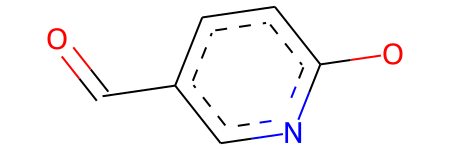

Reactant

Signature


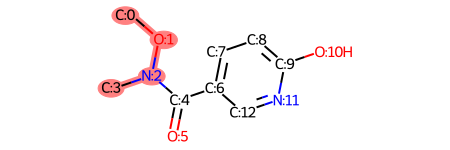

Centre at [2]
---------------------------------------------------------------------------------------------------- 
Product

Signature


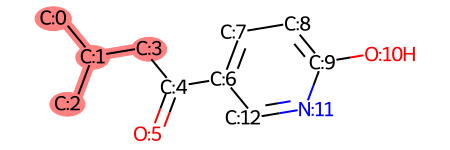

Centre at [3]
([2], [3])
('[CH3:0][O:1][NH:2][CH3:3]', '[CH3:0][CH:1]([CH3:2])[CH3:3]')


In [6]:
def highlight_atoms(mol, hit_ats):
    '''
    Highlight the atoms in mol that have index in 'hit_ats'
    '''
#     # this is the code given in rdkit docs but doesn't actually work
#     d = rdMolDraw2D.MolDraw2DSVG(500, 500) # or MolDraw2DCairo to get PNGs
#     rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=hit_ats,)
    mol.__sssAtoms = hit_ats # workaround for now. Might not work in a later version of rdkit

class RLMol:
    def __init__(self, mol):
        self.mol = mol
    
    def display_mol(self, atom_num=False, highlight=False):
        mol = Chem.Mol(self.mol)
        if atom_num:
            mol = mol_with_atom_index(mol)
        if highlight:
            highlight_atoms(mol, self.sig)
        display(mol)
        
    def calculate_centres_and_signatures(self, common_subsequence, debug=False):
        # input
        mol = Chem.Mol(self.mol)
        self.common_subsequence = common_subsequence
        cs = Chem.Mol(self.common_subsequence)
        
        # deal with atom indices
        mol_indices = list(range(mol.GetNumAtoms()))
        mol_indices_in_cs = rdchem.Mol(mol).GetSubstructMatch(cs)
        if not mol_indices_in_cs: # in some rare cases, GetSubstructureMatch returns empty tuple - rdkit algo problem
            cs = rdFMCS.FindMCS([mol, cs])
            self.common_subsequence = Chem.MolFromSmarts(cs.smartsString)
            cs = Chem.Mol(self.common_subsequence)
#             display(mcs)
            mol_indices_in_cs = rdchem.Mol(mol).GetSubstructMatch(cs)
            
        
        # find signature
        difference = list(set(mol_indices) - set(mol_indices_in_cs))
        self.sig = difference
        
        # find centre
        self.cen = []
        for idx in self.sig:
            atom = mol.GetAtomWithIdx(idx)
            neighbors = atom.GetNeighbors()
            neighbors_indices = list(map(lambda x: x.GetIdx(), neighbors))
            if set(neighbors_indices) - set(self.sig): # this atom has a neighbor outside of signature
                self.cen.append(idx)

        # if debug, display
        if debug:
            print("Signature")
            self.display_mol(atom_num=True, highlight=True)
            
            print("Centre at", self.cen)
    
    def try_to_merge(self, debug=False):
        ''' 
        if more than 1 centre, tries to merge them into 1 if they have a common atom
        Returns True if merge happens, else False
        '''
        mol = Chem.Mol(self.mol)
        cs = Chem.Mol(self.common_subsequence)
        if len(self.cen) < 2:
            return False
        
        conn_atom_d = {}
        conn_idx_list = []
        mol_indices_in_cs = rdchem.Mol(mol).GetSubstructMatch(cs)
        for cen in self.cen:
            cen_atom = mol.GetAtomWithIdx(cen)
            cen_neighbors_indices = list(map(lambda x: x.GetIdx(), cen_atom.GetNeighbors()))
            
            connecting_atom_idx = list(set(cen_neighbors_indices).intersection(set(mol_indices_in_cs)))[0]
            connecting_atom = mol.GetAtomWithIdx(connecting_atom_idx)
            
            conn_atom_d[cen] = [connecting_atom]
            conn_idx_list.append(connecting_atom_idx)
            
        # if they have common atom, merge
        if len(np.unique(conn_idx_list)) == 1:
            self.sig.append(conn_idx_list[0])
            self.cen = [conn_idx_list[0]]
            
            # if debug, display
            if debug:
                print("Signature")
                self.display_mol(atom_num=True, highlight=True)
                        
            return True
        return False
    
    def get_centre_in_cs(self):
        mol_indices_in_cs = np.array(rdchem.Mol(self.mol).GetSubstructMatch(rdchem.Mol(self.common_subsequence)))
        return int(abs(mol_indices_in_cs - self.cen[0]).argmin())
        
    
    def push_back_centre(self, cs_centre, debug):
        '''
        This function adds the adjoining atom from common subsequence (cs) to the signature
        In case singature is null, cs_centre is used to determine the atom to be added.
        '''
        mol = Chem.Mol(self.mol)
        cs = Chem.Mol(self.common_subsequence)
        
        if self.cen:
            cen = self.cen[0]
            cen_atom = mol.GetAtomWithIdx(cen)
            cen_neighbors_indices = list(map(lambda x: x.GetIdx(), cen_atom.GetNeighbors()))
            mol_indices_in_cs = rdchem.Mol(mol).GetSubstructMatch(cs)
            connecting_atom_idx = list(set(cen_neighbors_indices).intersection(set(mol_indices_in_cs)))[0]

            self.sig.append(connecting_atom_idx)
            self.cen = [connecting_atom_idx]

        else:
            # calculate the reaction centre from common subsequence and use it for signature
            self.cen = [int(rdchem.Mol(mol).GetSubstructMatch(cs)[cs_centre])]
            self.sig = list(self.cen)
        
        # if debug, display
        if debug:
            print("Signature")
            self.display_mol(atom_num=True, highlight=True)
            
     
    def get_signature(self):
        # calc Mol from list of ints
        sig = None
        mol = mol_with_atom_index(self.mol)
        with Chem.RWMol(mol) as mw:
            for idx in set(list(range(self.mol.GetNumAtoms()))) - set(self.sig):
                mw.RemoveAtom(idx)
            sig = Chem.Mol(mw)
        return mw
    
    def get_smiles_signature(self):
        return Chem.MolToSmiles(self.get_signature())
    
    def get_centre(self):
        return self.cen
                
            
        

class Reaction:
    def __init__(self, reactant, product, debug=False):
        self.reactant = RLMol(reactant)
        self.product = RLMol(product)
        self.debug = debug
        
    def _GetMCS(self):
        '''Get the Maximum common subsequence from reactant and product'''
        mcs = rdFMCS.FindMCS([self.reactant.mol, self.product.mol])
        return Chem.MolFromSmarts(mcs.smartsString)
    
    def display_reactant(self, atom_num=False, highlight=False):
        self.reactant.display_mol(atom_num, highlight)
            
            
    def display_product(self, atom_num=False, highlight=False):
        self.product.display_mol(atom_num, highlight)
    
    def calculate_centres_and_signatures(self):
        '''
        Calculates centres and signatures from reactants and products
        Returns None
        '''
        mcs = self._GetMCS()
        display(mcs)
        if self.debug:
            print("Reactant\n")
        self.reactant.calculate_centres_and_signatures(mcs, self.debug)
        
        if self.debug:
            print("-"*100, "\nProduct\n")
        self.product.calculate_centres_and_signatures(mcs, self.debug)
        
        # if unequal signatures/centres obtained, try to fix:
        # CASE 1: More than 1 signature - try to merge them to reduce count
        rcen, pcen = self.get_centres()
        rmerge, pmerge = False, False
        if len(rcen) > 1:
            rmerge = self.reactant.try_to_merge(self.debug)
        if len(pcen) > 1:
            pmerge = self.product.try_to_merge(self.debug)
        
        # if only one merge was successful, push back the centre by one atom in the other
        if rmerge and not pmerge:
            self.product.push_back_centre(self.reactant.get_centre_in_cs(), self.debug)
        elif pmerge and not rmerge:
            self.reactant.push_back_centre(self.product.get_centre_in_cs(), self.debug)
            
        # CASE 2: Reactant signature is Hydrogen
        rcen, pcen = self.get_centres()
        if len(rcen) == 0 and len(pcen) != 0:
            self.reactant.push_back_centre(self.product.get_centre_in_cs(), self.debug)
            self.product.push_back_centre(self.reactant.get_centre_in_cs(), self.debug)
    
    def get_signatures(self):
        # calc Mol from atom indices
        return self.reactant.get_signature(), self.product.get_signature()
    
    def get_smiles_signatures(self):
        return self.reactant.get_smiles_signature(), self.product.get_smiles_signature()
    
    def get_centres(self):
        # calc 
        return self.reactant.get_centre(), self.product.get_centre()
        

i = 0
mol1 = Chem.MolFromSmiles(dataset["reactants"].iloc[i])
mol2 = Chem.MolFromSmiles(dataset["products"].iloc[i])
R = Reaction(mol1, mol2, debug=True)
R.calculate_centres_and_signatures()
print(R.get_centres())
print(R.get_smiles_signatures())

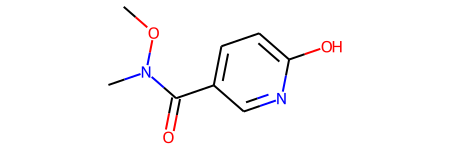

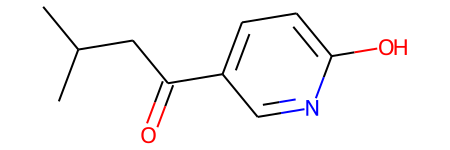

In [7]:
display(mol1)
display(mol2)

In [9]:
cs = rdFMCS.FindMCS([mol1, mol2])

cs = Chem.MolFromSmarts(cs.smartsString)

In [17]:
mol2.GetSubstructMatch(cs)

(4, 5, 6, 7, 8, 9, 11, 12, 10)

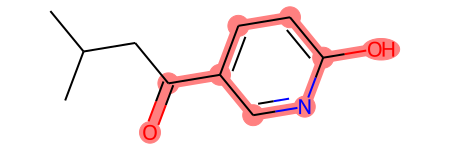

In [18]:
mol2

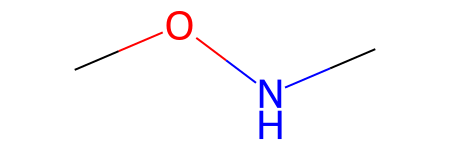

In [19]:
Chem.MolFromSmiles("CONC")

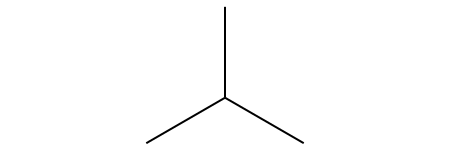

In [20]:
Chem.MolFromSmiles("CC(C)C")

In [9]:
rsig_list = []
psig_list = []
rcen_list = []
pcen_list = []

n = 259430
for i in range(n, n+100):
#     if i not in [487]:
        mol1 = Chem.MolFromSmiles(dataset["reactants"].iloc[i])
        mol2 = Chem.MolFromSmiles(dataset["products"].iloc[i])

        R = Reaction(mol1, mol2)
        R.calculate_centres_and_signatures()

        rcen, pcen = R.get_centres()
        rsig, psig = R.get_smiles_signatures()

        rsig_list.append(rsig)
        psig_list.append(psig)    
        rcen_list.append(rcen)    
        pcen_list.append(pcen)    

        print(i)

KeyboardInterrupt: 

In [33]:
df = dataset.iloc[:100]

df = df.drop("reagents", axis=1)

In [36]:
df["rsig"] = rsig_list
df["psig"] = psig_list
df["rcen"] = rcen_list
df["pcen"] = pcen_list